<a href="https://colab.research.google.com/github/soomin9106/Deep-Learning/blob/main/AnoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AnoGAN 구현
** 하드웨어 가속기를 GPU 로 설정 **

코드 참고 


DCGAN 구현 파트 : tensorflow 공식 사이트


Anomaly Detection 구현 파트 : https://github.com/mullue/anogan-mnist/blob/master/dcgan%2Banogan.ipynb

1. 28* 28 * 3 시도 : 아예 안됨

2. 64 * 64 * 3 시도 : 맞는 결과가 나오긴 함 (정상 데이터의 loss 값이 비정상 데이터의 loss 값보다 작음)

3. 128 * 128 * 3 시도 : 가능할까...?

### Module install & import



In [ ]:
pip install -q tensorflow-gpu==2.0.0-rc1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1


In [ ]:
import tensorflow as tf

In [ ]:
pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
from tensorflow.keras.layers import *

In [ ]:
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import albumentations as A

### Dataset loading and preparing

In [ ]:
path = '/content/drive/MyDrive/dataset' #your path
train_images = []

#/content/drive/MyDrive/dataset/KEMP_IMG_DATA_1.png (example)

for item in os.listdir(path):
  #print(item)
  imgpath = path +'/' + item
  f = cv2.imread(imgpath)
  f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
  train_images.append(f)

In [ ]:
train_images = np.array(train_images)
print(train_images.shape)

(1102, 720, 480, 3)


In [ ]:
#이미지 resizing (높이와 너비 맞추기)
tr_images = []
for image in train_images:
  image = cv2.resize(image, dsize = (128, 128),interpolation = cv2.INTER_NEAREST)
  tr_images.append(image)

In [ ]:
tr_images = np.array(tr_images)
print(tr_images.shape)

(1102, 128, 128, 3)


In [ ]:
#[-1 ~ 1] 로 정규화 
tr_images = (tr_images - 127.5) / 127.5

In [ ]:
augmentor = A.Compose([
  A.HorizontalFlip(p = 0.5),
  A.VerticalFlip(p = 0.5),
  A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_REPLICATE)                  
])

augmented_images = []

for img in tr_images:
  augmented = augmentor(image = img)['image']
  augmented_images.append(augmented)

In [ ]:
BUFFER_SIZE = 1102
BATCH_SIZE = 64 

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(augmented_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Model Part

#### generator
생성자는 시드값 (seed; 랜덤한 잡음)으로부터 이미지를 생성하기 위해, tf.keras.layers.Conv2DTranspose (업샘플링) 층을 이용합니다. 처음 Dense층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 tf.keras.layers.LeakyReLU을 사용하고 있음을 주목합시다.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4,4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (4,4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

아직 훈련되지 않은 생성자를 사용하여 이미지 생성해보기

#### Discriminator
감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다.

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(4,4),strides=(2,2), padding='same', input_shape=[128,128,3]))

  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

#### Encoder

In [ ]:
def encoder(latent_dim = 100, ndf = 128, channels = 3):
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(ndf, kernel_size = (4,4), strides = 2, padding='same', input_shape=[128,128,3]))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(ndf*2, kernel_size = (4,4), strides = 2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(ndf*4, kernel_size = (4,4), strides = 2, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(0.2))

  model.add(layers.Conv2D(latent_dim, kernel_size = (4,4), strides = 1, padding='same'))
  model.add(layers.LeakyReLU(0.2))

  return model

#### loss function & optimizer

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

#### 감별자 손실 함수
이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

#### 생성자 손실함수
생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다.

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

#### optimizer of G and D

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Train Part

#### save check point

In [ ]:
#checkpoint_dir = '/content'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                discriminator_optimizer=discriminator_optimizer,
#                                generator=generator,
#                                discriminator=discriminator)


def save_models(epoch, discriminator, generator, path='/content'):
    discriminator.save_weights('{}/d-{}.ckpt'.format(path,epoch))
    generator.save_weights('{}/g-{}.ckpt'.format(path,epoch))

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### DCGAN 훈련

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  # save weights
  save_models(epochs, discriminator, generator, '/content')

#### 이미지 생성 및 저장

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5 )
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### DCGAN model training
*** time consuming ***

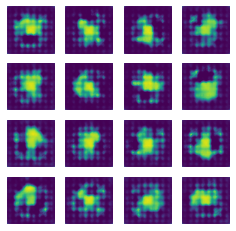

CPU times: user 8min 7s, sys: 4.35 s, total: 8min 11s
Wall time: 8min 8s


In [ ]:
%%time
train(train_dataset, EPOCHS)

#### Encoder Train

In [ ]:
criterion = tf.keras.losses.BinaryCrossentropy(from_logits = True)
encoder_optimizer =  tf.keras.losses.MeanSquaredError(
    name='mean_squared_error'
)
e_losses = []

def train_encoder(dataset, epochs):
  e = encoder(latent_dim = 100, ndf = 128, channels = 3)
  discriminator.trainable = False
  generator.trainable = False
  for epoch in range(epochs):
    for step, image_batch in enumerate(dataset):
      real_imgs = image_batch

      with tf.GradientTape() as en_tape:
        z = e(real_imgs)

        print(z.shape)

        fake_imgs = generator(z)

        real = discriminator(real_imgs)
        fake = discriminator(fake_imgs)

        loss_imgs = criterion(fake_imgs, real_imgs)
        loss_features = criterion(fake, real)
        e_loss = loss_imgs + 1.0 * loss_features 

      gradients_of_encoder = en_tape.gradient(e_loss, e.trainable_variables)
      encoder_optimizer.apply_gradients(zip(gradients_of_encoder, e.trainable_variables))

      if step % 10 == 0:
        e_losses.append(e_loss)
        print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(e_loss))
            )
  # save weights
  e.save_weights('{}/e-{}.ckpt'.format('/content',epoch))

In [ ]:
train_encoder(train_dataset, 100)

0
(64, 16, 16, 100)


ValueError: ignored

### Anomaly Detection Part

#### AnoGAN 생성
AnoGAN 네트워크를 생성합니다. AnoGAN 네트워크의 정의와 학습은 다음 단계를 거칩니다.



(1) size 100의 임의의 z를 입력받습니다.

(2) 입력된 z는 Dense layer를 지나 generator에 입력하기 위한 latent vector를 생성합니다.

(3) latent vector는 fix된 generator를 거쳐 임의의 이미지를 생성합니다.

(4) 3)의 결과를 입력으로 하여 fix된 Discriminnator를 거쳐 Real/Fake 판단을 위한 feature vector를 생성합니다.

(5) normal/abnormal 판단을 위한 이미지를 이용하여 3), 4)에 대한 Ground truth 값을 생성합니다. (이미지 자체는 3)의 ground truth 역할을 하고, 해당 이미지로부터 Discriminator 연산을 통해 생성한 feature vector는 4)에 대한 ground truth가 됩니다.)

(6) 생성된 (a), (b) 값을 ground truth와 비교하여 2)의 Dense layer를 학습합니다.

(7) 학습과정에서 사용했던 데이터(정상데이터)일 수록 학습이 더 잘 될 것입니다. 이런 원리로 6) training 작업 loss 자체가 abnoaly score 역할을 할 수 있습니다.

AnoGAN 생성시 이전 단계에서 학습된 Generator와 Discriminator 네트워크와 Weight를 로드하여 사용합니다. 아래에서 호출하고 있는 make_discriminator_model()와 make_generator_model()는 앞서 DCGAN학습단계에서 생성한 동일한 함수입니다.

In [ ]:
path = '/content/drive/MyDrive/test_dataset' #your path
test_images = []

for item in os.listdir(path):
  #print(item)
  imgpath = path +'/' + item
  f = cv2.imread(imgpath)
  f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
  test_images.append(f)

test_images = np.array(test_images)

#이미지 resizing (높이와 너비 맞추기)
ts_images = []
for image in test_images:
  image = cv2.resize(image, dsize = (64,64),interpolation = cv2.INTER_NEAREST)
  ts_images.append(image)

ts_images = np.array(ts_images)

ts_images = (ts_images / 255.0) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print(ts_images.shape)

(59, 64, 64, 3)


In [ ]:
#Discriminator 로부터 feature 를 도출하는 함수
from tensorflow.keras.models import Model

def feature_extractor():
    d = make_discriminator_model()
    d.load_weights('/content/d-50.ckpt') #discriminator model weigth 저장된 파일
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-6].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

In [ ]:
#임의의 z로부터 latent vector를 생성하고 Generator와 앞서 feature_extractor를 호출합니다.
from tensorflow.keras.layers import Layer, Input, Dense, Flatten

def gne_anogan(loss, latent_dim = 100, channels = 1, img_shape=(28,28,3)):
  g = make_generator_model()
  g.load_weights('/content/g-50.ckpt')
  g.trainable = False
  intermidiate_model = feature_extractor(img_shape)
  intermidiate_model.trainable = False

  z = Input(shape=(100,))
  gInput = Dense((100))(z)
  G_out = g(gInput)
  D_out = intermidiate_model(G_out)    
  model = Model(inputs=z, outputs=[G_out, D_out])
  model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')

  return model

In [ ]:
def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

In [ ]:
model = gne_anogan(loss=sum_of_residual)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 3)         6036992   
                                                                 
 model (Functional)          (None, 8, 8, 256)         658880    
                                                                 
Total params: 6,705,972
Trainable params: 10,100
Non-trainable params: 6,695,872
_________________________________________________________________


#### 정상 데이터 테스팅

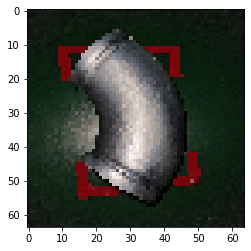

In [ ]:
nimg = tr_images[1].reshape(64,64,3)
plt.figure(figsize=(4,4))
plt.imshow(nimg)

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = nimg.reshape(1,64,64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 4.95 s, sys: 272 ms, total: 5.22 s
Wall time: 4.55 s


학습을 통해 best latent vector를 추정한 후, 해당 latent vector를 이용하여 생성한 생성 이미지입니다. (500 epoch을 거쳐 원본과 유사한 결과를 생성할 수 있는 z를 찾았고 그 z를 이용하여 생성한 이미지입니다.) 원본 이미지와 유사한 이미지를 생성하고 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


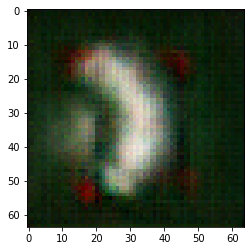

In [ ]:
o1, o2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(o1.reshape(64,64,3))

In [ ]:
loss.history['loss'][-1]

662.0726928710938

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


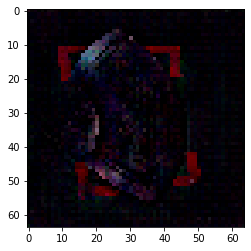

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(nimg - o1.reshape(64,64,3))

#### 이상 데이터 테스트

불량 데이터 => 이상 데이터

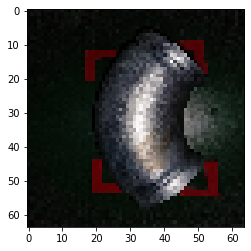

In [ ]:
aimg = ts_images[2].reshape(64,64,3)
plt.figure(figsize=(4,4))
plt.imshow(aimg)

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = aimg.reshape(1, 64, 64, 3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 4.1 s, sys: 266 ms, total: 4.37 s
Wall time: 3.68 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


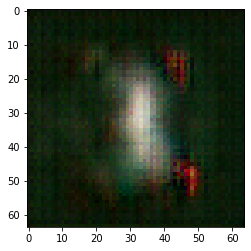

In [ ]:
oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(oa1.reshape(64,64,3))

In [ ]:
loss_a.history['loss'][-1]

929.8133544921875

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


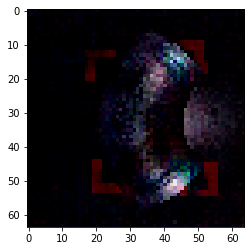

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(aimg - oa1.reshape(64,64,3))

#### 결과 검증

각 50건의 정상과 비정상 이미지를 이용하여 Anobal loss를 비교해봅니다.

In [ ]:
nimg_multi = tr_images[:50]

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(50, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = nimg_multi.reshape(50,64,64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_normal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 18.6 s, sys: 484 ms, total: 19.1 s
Wall time: 20.8 s


비정상 이미지 로 학습

In [ ]:
aimg_multi = ts_images[:50]

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(50, 100))
intermidiate_model = feature_extractor(img_shape=(64,64,3))

# ground truth
x = aimg_multi.reshape(50,64,64,3)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_abnormal = model.fit(z, [x, d_x], epochs=500, verbose=0)

CPU times: user 18.4 s, sys: 480 ms, total: 18.9 s
Wall time: 20.7 s


plot 을 그려 정상 데이터와 비정상 데이터의 loss 값 시각화

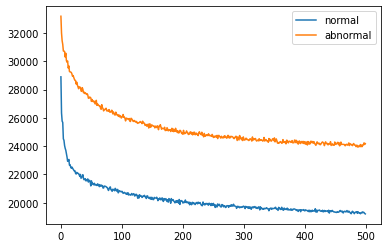

In [ ]:
plt.plot(loss_normal.history['loss'])
plt.plot(loss_abnormal.history['loss'])
plt.legend(['normal','abnormal'])
plt.show()